Notebook purpose

- Check whether there is a reliable way to identify savings transactions

In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import s3fs
import seaborn as sns

sys.path.append("/Users/fgu/dev/projects/entropy")
import entropy.data.cleaners as cl
import entropy.data.creators as cr
import entropy.data.txn_classifications as tc
import entropy.figures.figures as figs
import entropy.helpers.aws as ha
import entropy.helpers.data as hd
import entropy.helpers.helpers as hh
from entropy import config

sns.set_style("whitegrid")
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)
pd.set_option("max_colwidth", None)
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

fs = s3fs.S3FileSystem(profile="3di")

In [2]:
dfs, df = hd.read_samples(["777", "XX7"])
hd.inspect(df)

Time for read_data      : 1.90 seconds
Time for read_data      : 2.82 minutes
(6,791,894, 32)


,id,date,user_id,amount,desc,merchant,tag_group,tag,user_female,user_postcode,user_registration_date,user_salary_range,user_yob,account_created,account_id,account_last_refreshed,account_provider,account_type,data_warehouse_date_created,data_warehouse_date_last_updated,debit,latest_balance,merchant_business_line,tag_auto,tag_manual,tag_up,updated_flag,ym,savings,balance,income,entropy_sptac
0,19510816,2014-03-07,107,9.20,paypal sandrpowell 9001,paypal,spend,services,0.0,gl3 4,2010-05-10,40k to 50k,1984.0,2014-05-11,238820,2020-08-16 12:13:00,barclaycard,credit card,2014-07-18,2017-09-12,True,NaN,paypal,enjoyment,home electronics,home electronics,u,201403,0.0,NaN,27530.926758,3.019948
1,19510817,2014-03-08,107,6.94,paypal smartbitsso 9001,paypal,spend,services,0.0,gl3 4,2010-05-10,40k to 50k,1984.0,2014-05-11,238820,2020-08-16 12:13:00,barclaycard,credit card,2014-07-18,2017-09-12,True,NaN,paypal,enjoyment,home electronics,home electronics,u,201403,0.0,NaN,27530.926758,3.019948


In [170]:
def make_data(df, windows=[1], trim_pct=None):
    user_daily_balance = (
        df.loc[df.account_type.eq("current")]
        .set_index("date")
        .groupby("user_id")
        .resample("d")
        .balance.first()
        .ffill()
        .reset_index("user_id")
        .groupby("user_id")
    )
    frames = []
    for window in windows:
        df = user_daily_balance.rolling(window=window).min()
        if trim_pct:
            df["balance"] = hd.trim(df.balance, pct=trim_pct)
        df["n"] = window
        frames.append(df)
    return pd.concat(frames, axis=0).reset_index()


def make_figure(data):
    sns.displot(data, x="balance", kind="ecdf", hue="n", height=3, aspect=2)
    plt.suptitle("CDF of minimum current account balance in past $n$ days", y=1.025)

## Account balance in past n days

In [171]:
data = dfs
windows = [1, 30, 60, 90]

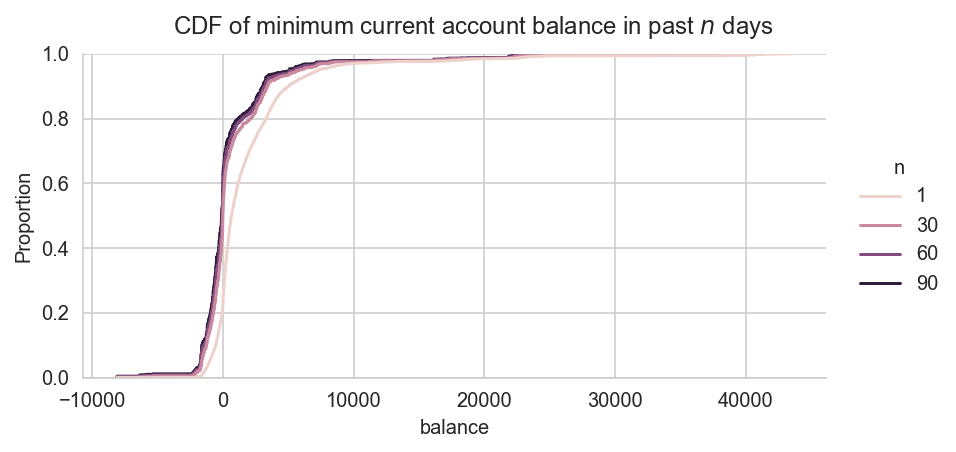

In [172]:
make_data(data, windows, trim_pct=0).pipe(make_figure)

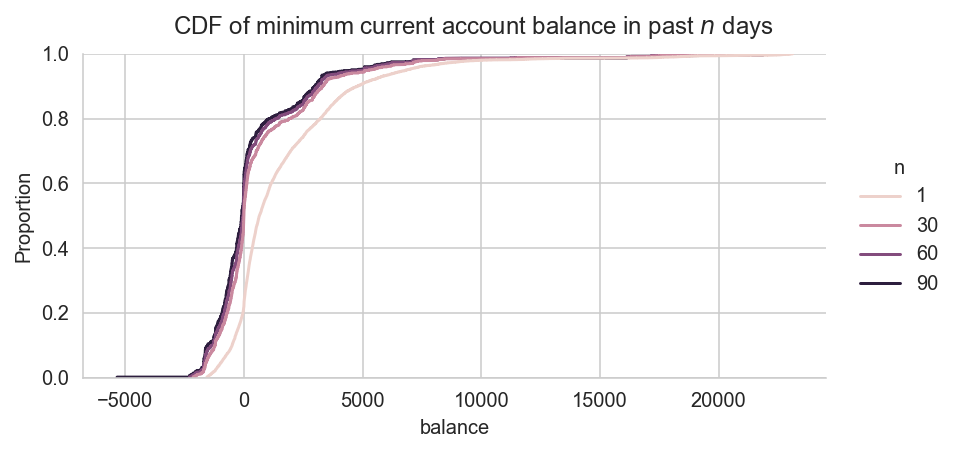

In [173]:
make_data(data, windows, trim_pct=1).pipe(make_figure)

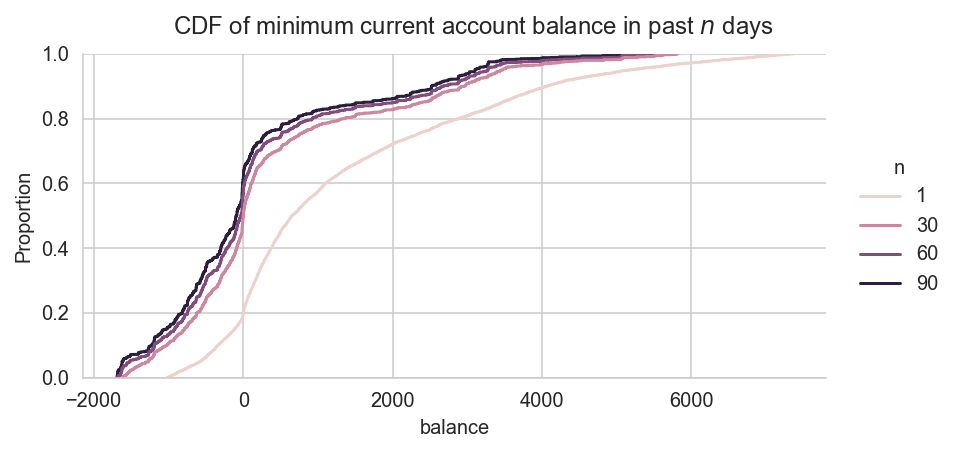

In [174]:
make_data(data, windows, trim_pct=5).pipe(make_figure)

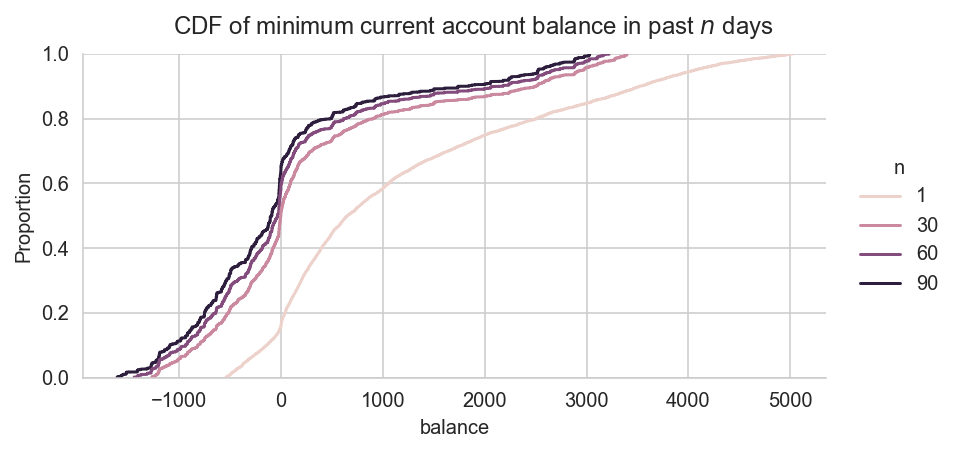

In [175]:
make_data(data, windows, trim_pct=10).pipe(make_figure)